In [10]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time

data = pd.read_csv("../data/adhdata.csv")

channel_names = data.columns.tolist()
channel_names.remove('Class')
channel_names.remove('ID')

sfreq = 128  # Sampling frequency in Hz

info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Parameters from the paper
segment_length = 2  # seconds
overlap = 1         # seconds (50% overlap)
step = segment_length - overlap  # 1 second step

n_samples = int(segment_length * sfreq)
step_samples = int(step * sfreq)

all_segments = []
all_labels = []

total_patients = data['ID'].nunique()
total_segments = 0

with tqdm(total=total_patients, desc="Processing patients") as pbar_patients:
    for patient_id in data['ID'].unique():
        start_time = time.time()
        patient = data[data.ID == patient_id]
        eeg_data = patient.drop(['Class', 'ID'], axis=1).values.T
        raw = mne.io.RawArray(eeg_data, info, verbose=False)
        filtered = raw.copy().filter(l_freq=1., h_freq=45., fir_design='firwin', verbose=False)
        label = patient['Class'].iloc[0]
        
        n_patient_segments = 0
        for start in range(0, filtered.n_times - n_samples + 1, step_samples):
            stop = start + n_samples
            segment = filtered.get_data(start=start, stop=stop)
            all_segments.append(segment)
            all_labels.append(label)
            n_patient_segments += 1
            total_segments += 1

        elapsed = time.time() - start_time
        #print(f"Patient {patient_id}: {n_patient_segments} segments in {elapsed:.2f} seconds")
        pbar_patients.update(1)

print(f"Total segments created: {len(all_segments)}")
print(f"Total labels collected: {len(all_labels)}")

Processing patients:   0%|          | 0/121 [00:00<?, ?it/s]

Total segments created: 16749
Total labels collected: 16749


In [11]:
# Augment segments using FFT augmentation
def fft_augmentation(eeg_data, noise_level=0.05, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    eeg_aug = np.zeros_like(eeg_data)
    for ch in range(eeg_data.shape[0]):
        fft_vals = np.fft.rfft(eeg_data[ch])
        noise = np.random.normal(0, noise_level * np.std(np.abs(fft_vals)), size=fft_vals.shape)
        fft_vals_noisy = fft_vals + noise
        eeg_aug[ch] = np.fft.irfft(fft_vals_noisy, n=eeg_data.shape[1])
    return eeg_aug

# Augment all segments with a progress bar
augmented_segments = []
with tqdm(total=len(all_segments), desc="Augmenting segments") as pbar_aug:
    for seg in all_segments:
        augmented_segments.append(fft_augmentation(seg, noise_level=0.1))
        pbar_aug.update(1)

augmented_labels = list(all_labels)  # Use the same labels for augmented data

# Combine original and augmented data
all_segments_combined = all_segments + augmented_segments
all_labels_combined = list(all_labels) + augmented_labels

print(f"Total segments after augmentation: {len(all_segments_combined)}")

Augmenting segments:   0%|          | 0/16749 [00:00<?, ?it/s]

Total segments after augmentation: 33498


In [12]:
from scipy.signal import spectrogram

# Spectrogram extraction
spec_segments = []
with tqdm(total=len(all_segments_combined), desc="Extracting spectrograms") as pbar_specs:
    for segment in all_segments_combined:
        specs = []
        for ch_data in segment:
            f, t, Sxx = spectrogram(
                ch_data,
                fs=sfreq,
                window='hann',
                nperseg=256,
                noverlap=128,
                nfft=256,
                scaling='density',
                mode='magnitude'
            )
            specs.append(Sxx)
        spec_segments.append(np.stack(specs, axis=0))
        pbar_specs.update(1)

spec_segments = np.array(spec_segments)
all_labels = np.array(all_labels_combined)
print(f"Spectrogram data shape: {spec_segments.shape}")
print(f"Labels shape: {all_labels.shape}")

Extracting spectrograms:   0%|          | 0/33498 [00:00<?, ?it/s]

Spectrogram data shape: (33498, 19, 129, 1)
Labels shape: (33498,)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integers (e.g., 'ADHD'->1, 'Control'->0)
le = LabelEncoder()
all_labels = le.fit_transform(all_labels)
print(f"Unique classes: {le.classes_}")

Unique classes: ['ADHD' 'Control']


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    spec_segments, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train.shape[1:]  # (channels, freq_bins, time_bins)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first'),
    layers.MaxPooling2D((2, 1), data_format='channels_first'),  # Only pool freq axis
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first'),
    layers.MaxPooling2D((2, 1), data_format='channels_first'),  # Only pool freq axis
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 129, 1)     │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 1)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,201 (606.25 KB)

 Trainable params: 155,201 (606.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8438 - loss: 0.4230 - val_accuracy: 0.9756 - val_loss: 0.0902
Epoch 2/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9816 - loss: 0.0591 - val_accuracy: 0.9722 - val_loss: 0.0851
Epoch 3/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9890 - loss: 0.0346 - val_accuracy: 0.9948 - val_loss: 0.0249
Epoch 4/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9915 - loss: 0.0270 - val_accuracy: 0.9927 - val_loss: 0.0361
Epoch 5/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9946 - loss: 0.0214 - val_accuracy: 0.9944 - val_loss: 0.0387
Epoch 6/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9947 - loss: 0.0159 - val_accuracy: 0.9821 - val_loss: 0.0639
Epoch 7/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9970 - loss: 0.0111 - val_accuracy: 0.9933 - val_loss: 0.0161
Epoch 8/20
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9977 - loss: 0.0094 - val_accuracy: 0

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.0010  
Test accuracy: 1.00
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3737
           1       1.00      1.00      1.00      2963

    accuracy                           1.00      6700
   macro avg       1.00      1.00      1.00      6700
weighted avg       1.00      1.00      1.00      6700



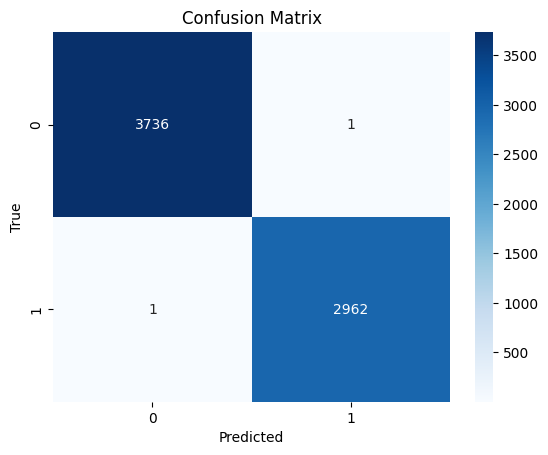

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = y_test

print(classification_report(y_true, y_pred_classes))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()